In [1]:
import torch
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics

from torch import nn
from copy import deepcopy
from tqdm import tqdm

from bayes_opt import BayesianOptimization

In [2]:
# Use the following gym version.
# pip install gym==0.25.0
# pip install pygame

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# define global variable 
MAX_EP = 1
env = gym.make('CartPole-v1')

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# Define network architecture
class Network(nn.Module):
    def __init__(self, env):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, x):
        return self.net(x)

    def act(self, state):
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = self.forward(state_t.unsqueeze(0))                           # 'q_values' outputs two values (left or right)
        max_q_index = torch.argmax(q_values, dim=1)[0]                          # find an index that corresponds to the maximum value  
        action = max_q_index.detach().item()                                    # 0 or 1
        return action                                                           # 0 or 1

In [4]:
def calculate_fitness(network, env, num_episodes=MAX_EP):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

In [5]:
def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    log_probs = []  # Store log probabilities of actions
    done = False
    while not done:
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = network(state_t.unsqueeze(0))
        action_probs = nn.functional.softmax(q_values, dim=1)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        log_probs.append(log_prob)
        state, reward, done, _ = env.step(action.item())
        total_reward += reward
    return total_reward, log_probs

In [6]:
def mutate_and_tournament(population, tournament_size, mutation_rate, mutation_strength):
    
    # Select individuals for the tournament
    individuals = random.sample(population, tournament_size)
    # Calculate fitness for each individual
    fitnesses = [calculate_fitness(individual, env) for individual in individuals]
    # Select the best individual
    parent = individuals[np.argmax(fitnesses)]
    # Create offspring by deep copying the parent
    offspring = deepcopy(parent)
    
    # Apply mutation
    with torch.no_grad():
        for param in offspring.parameters():
            if random.random() < mutation_rate:
                delta = torch.randn_like(param)
                param.add_(mutation_strength * delta)
    
    # Return the mutated offspring
    return offspring

In [7]:
# Define genetic algorithm
def main(POPULATION_SIZE, GENERATIONS, ELITISM, TOURNAMENT_SIZE, MUTATION_STRENGTH, MUTATION_RATE):
    
    FITNESS_HISTORY = list()
    FITNESS_STDERROR_HISTORY = list()
    
    # Create initial population
    population = [Network(env) for _ in range(POPULATION_SIZE)]

    for generation in range(1, GENERATIONS + 1):

        # Calculate fitness for each network
        fitnesses = [calculate_fitness(network, env) for network in tqdm(population, desc="Calculating fitnesses")]
        
        # average fitness 
        avg_fitness = np.average(fitnesses)
        max_fitness = np.max(fitnesses)
        min_fitness = np.min(fitnesses)
        FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
        
        # std error
        standard_deviation = statistics.stdev(fitnesses)
        standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
        FITNESS_STDERROR_HISTORY.append(standard_error)

        print(f"[Generation: {generation}] \n Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")
        
        # Sort population by fitness
        population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
        
        # Select the best networks to pass their genes to the next generation
        survivors = population[:ELITISM]
        
        # Create the next generation
        next_population = survivors  # Start with the survivors
        
        num_individuals_to_add = POPULATION_SIZE - len(next_population)
        # Add offspring by tournament selection and mutation
        for _ in tqdm(range(num_individuals_to_add), desc="Generating Offspring"):
            offspring = mutate_and_tournament(population, TOURNAMENT_SIZE, MUTATION_RATE, MUTATION_STRENGTH)
            next_population.append(offspring)

        # The next generation becomes the current population
        population = next_population

    return population, FITNESS_HISTORY, FITNESS_STDERROR_HISTORY

### Version Control

In [8]:
# Version 1:
# Run the genetic algorithm
population, history, history_std = main(POPULATION_SIZE=200, 
                            GENERATIONS=90, 
                            ELITISM=100, 
                            TOURNAMENT_SIZE=3, 
                            MUTATION_STRENGTH=1, 
                            MUTATION_RATE=0.01)

Calculating fitnesses:   0%|                                       | 0/200 [00:00<?, ?it/s]/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 603.38it/s]


[Generation: 1] 
 Average Fitness: 21.29 
 Best Fitness: 64.0 
 Worst Fitness: 8.0 
 Standard Error: 0.8187989119994343


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 595.21it/s]


[Generation: 2] 
 Average Fitness: 20.77 
 Best Fitness: 84.0 
 Worst Fitness: 9.0 
 Standard Error: 0.8207641371576984


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 569.89it/s]


[Generation: 3] 
 Average Fitness: 22.655 
 Best Fitness: 122.0 
 Worst Fitness: 9.0 
 Standard Error: 0.9740501751545415


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 489.56it/s]


[Generation: 4] 
 Average Fitness: 23.12 
 Best Fitness: 76.0 
 Worst Fitness: 9.0 
 Standard Error: 0.84572706670461


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 500.85it/s]


[Generation: 5] 
 Average Fitness: 23.94 
 Best Fitness: 78.0 
 Worst Fitness: 9.0 
 Standard Error: 0.9447192558436655


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 539.22it/s]


[Generation: 6] 
 Average Fitness: 24.795 
 Best Fitness: 75.0 
 Worst Fitness: 9.0 
 Standard Error: 0.9191786124622571


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 509.16it/s]


[Generation: 7] 
 Average Fitness: 25.45 
 Best Fitness: 105.0 
 Worst Fitness: 9.0 
 Standard Error: 1.0268199922490855


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 495.10it/s]


[Generation: 8] 
 Average Fitness: 26.055 
 Best Fitness: 103.0 
 Worst Fitness: 8.0 
 Standard Error: 1.0968249632461873


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 471.42it/s]


[Generation: 9] 
 Average Fitness: 27.365 
 Best Fitness: 91.0 
 Worst Fitness: 8.0 
 Standard Error: 1.0281998099816159


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 462.47it/s]


[Generation: 10] 
 Average Fitness: 28.49 
 Best Fitness: 86.0 
 Worst Fitness: 8.0 
 Standard Error: 1.122116404893295


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 388.09it/s]


[Generation: 11] 
 Average Fitness: 32.965 
 Best Fitness: 102.0 
 Worst Fitness: 9.0 
 Standard Error: 1.3770257348255548


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 388.29it/s]


[Generation: 12] 
 Average Fitness: 33.77 
 Best Fitness: 120.0 
 Worst Fitness: 9.0 
 Standard Error: 1.2100024917952663


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 327.01it/s]


[Generation: 13] 
 Average Fitness: 39.965 
 Best Fitness: 131.0 
 Worst Fitness: 8.0 
 Standard Error: 1.377427094989078


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 269.76it/s]


[Generation: 14] 
 Average Fitness: 37.665 
 Best Fitness: 237.0 
 Worst Fitness: 10.0 
 Standard Error: 1.609570583202724


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 260.48it/s]


[Generation: 15] 
 Average Fitness: 47.195 
 Best Fitness: 292.0 
 Worst Fitness: 10.0 
 Standard Error: 2.5302560847217332


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 251.00it/s]


[Generation: 16] 
 Average Fitness: 50.675 
 Best Fitness: 250.0 
 Worst Fitness: 9.0 
 Standard Error: 2.4938914063634905


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 208.83it/s]


[Generation: 17] 
 Average Fitness: 60.855 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 3.781868921272714


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 144.78it/s]


[Generation: 18] 
 Average Fitness: 83.2 
 Best Fitness: 392.0 
 Worst Fitness: 10.0 
 Standard Error: 4.508194660335486


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 110.44it/s]


[Generation: 19] 
 Average Fitness: 113.415 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 6.360712001089502


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:02<00:00, 77.65it/s]


[Generation: 20] 
 Average Fitness: 162.17 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 6.742183674709373


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:03<00:00, 61.51it/s]


[Generation: 21] 
 Average Fitness: 205.195 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 8.394948521485523


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 44.94it/s]


[Generation: 22] 
 Average Fitness: 274.6 
 Best Fitness: 500.0 
 Worst Fitness: 71.0 
 Standard Error: 9.13982670299629


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 36.55it/s]


[Generation: 23] 
 Average Fitness: 339.285 
 Best Fitness: 500.0 
 Worst Fitness: 79.0 
 Standard Error: 8.650861570070498


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 35.36it/s]


[Generation: 24] 
 Average Fitness: 353.795 
 Best Fitness: 500.0 
 Worst Fitness: 91.0 
 Standard Error: 7.532430045273216


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 36.02it/s]


[Generation: 25] 
 Average Fitness: 349.19 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 8.281857601204766


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 36.34it/s]


[Generation: 26] 
 Average Fitness: 345.03 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 8.01449349804158


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 36.43it/s]


[Generation: 27] 
 Average Fitness: 341.825 
 Best Fitness: 500.0 
 Worst Fitness: 118.0 
 Standard Error: 7.579814629931302


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 33.85it/s]


[Generation: 28] 
 Average Fitness: 363.965 
 Best Fitness: 500.0 
 Worst Fitness: 64.0 
 Standard Error: 7.843665233580689


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 35.02it/s]


[Generation: 29] 
 Average Fitness: 355.62 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 8.71789461006273


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 33.86it/s]


[Generation: 30] 
 Average Fitness: 365.63 
 Best Fitness: 500.0 
 Worst Fitness: 38.0 
 Standard Error: 7.9262121911094745


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:06<00:00, 33.13it/s]


[Generation: 31] 
 Average Fitness: 373.125 
 Best Fitness: 500.0 
 Worst Fitness: 98.0 
 Standard Error: 7.425150583045742


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:06<00:00, 31.52it/s]


[Generation: 32] 
 Average Fitness: 397.255 
 Best Fitness: 500.0 
 Worst Fitness: 31.0 
 Standard Error: 7.058250090973942


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:06<00:00, 29.31it/s]


[Generation: 33] 
 Average Fitness: 417.02 
 Best Fitness: 500.0 
 Worst Fitness: 76.0 
 Standard Error: 6.083852753116896


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 28.47it/s]


[Generation: 34] 
 Average Fitness: 434.705 
 Best Fitness: 500.0 
 Worst Fitness: 55.0 
 Standard Error: 6.09831428021724


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 27.71it/s]


[Generation: 35] 
 Average Fitness: 448.15 
 Best Fitness: 500.0 
 Worst Fitness: 77.0 
 Standard Error: 5.948234609938849


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.36it/s]


[Generation: 36] 
 Average Fitness: 485.37 
 Best Fitness: 500.0 
 Worst Fitness: 210.0 
 Standard Error: 3.029754538376677


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.09it/s]


[Generation: 37] 
 Average Fitness: 487.07 
 Best Fitness: 500.0 
 Worst Fitness: 28.0 
 Standard Error: 3.476912437853808


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.35it/s]


[Generation: 38] 
 Average Fitness: 486.655 
 Best Fitness: 500.0 
 Worst Fitness: 67.0 
 Standard Error: 3.726157689987538


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.08it/s]


[Generation: 39] 
 Average Fitness: 497.12 
 Best Fitness: 500.0 
 Worst Fitness: 292.0 
 Standard Error: 1.3365101183614032


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.15it/s]


[Generation: 40] 
 Average Fitness: 489.42 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 4.405703019437124


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.85it/s]


[Generation: 41] 
 Average Fitness: 497.945 
 Best Fitness: 500.0 
 Worst Fitness: 316.0 
 Standard Error: 1.2629270758816498


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.89it/s]


[Generation: 42] 
 Average Fitness: 495.73 
 Best Fitness: 500.0 
 Worst Fitness: 74.0 
 Standard Error: 2.5005598368140354


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.09it/s]


[Generation: 43] 
 Average Fitness: 494.905 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 3.1012122568943195


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.78it/s]


[Generation: 44] 
 Average Fitness: 495.15 
 Best Fitness: 500.0 
 Worst Fitness: 21.0 
 Standard Error: 3.3512073126354487


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.96it/s]


[Generation: 45] 
 Average Fitness: 493.34 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 3.6129821755725593


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.80it/s]


[Generation: 46] 
 Average Fitness: 498.945 
 Best Fitness: 500.0 
 Worst Fitness: 395.0 
 Standard Error: 0.6644678038186334


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.80it/s]


[Generation: 47] 
 Average Fitness: 497.555 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 2.445


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.93it/s]


[Generation: 48] 
 Average Fitness: 495.115 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 3.4455285822432637


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.83it/s]


[Generation: 49] 
 Average Fitness: 497.485 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 2.4310592589657323


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.77it/s]


[Generation: 50] 
 Average Fitness: 498.585 
 Best Fitness: 500.0 
 Worst Fitness: 217.0 
 Standard Error: 1.4149999999999998


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.76it/s]


[Generation: 51] 
 Average Fitness: 497.965 
 Best Fitness: 500.0 
 Worst Fitness: 93.0 
 Standard Error: 2.035


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.80it/s]


[Generation: 52] 
 Average Fitness: 497.73 
 Best Fitness: 500.0 
 Worst Fitness: 104.0 
 Standard Error: 1.9996822611926732


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.00it/s]


[Generation: 53] 
 Average Fitness: 494.085 
 Best Fitness: 500.0 
 Worst Fitness: 144.0 
 Standard Error: 2.909564693995085


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.01it/s]


[Generation: 54] 
 Average Fitness: 495.11 
 Best Fitness: 500.0 
 Worst Fitness: 106.0 
 Standard Error: 2.8467983427036243


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.98it/s]


[Generation: 55] 
 Average Fitness: 492.735 
 Best Fitness: 500.0 
 Worst Fitness: 27.0 
 Standard Error: 3.484253721383515


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.92it/s]


[Generation: 56] 
 Average Fitness: 496.145 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 2.649655306111727


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.17it/s]


[Generation: 57] 
 Average Fitness: 490.89 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 4.316817585948213


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.82it/s]


[Generation: 58] 
 Average Fitness: 497.34 
 Best Fitness: 500.0 
 Worst Fitness: 33.0 
 Standard Error: 2.355891151046221


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.89it/s]


[Generation: 59] 
 Average Fitness: 495.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 3.442029318461092


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.85it/s]


[Generation: 60] 
 Average Fitness: 496.325 
 Best Fitness: 500.0 
 Worst Fitness: 22.0 
 Standard Error: 2.61466618736633


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.62it/s]


[Generation: 61] 
 Average Fitness: 497.95 
 Best Fitness: 500.0 
 Worst Fitness: 90.0 
 Standard Error: 2.05


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.71it/s]


[Generation: 62] 
 Average Fitness: 500.0 
 Best Fitness: 500.0 
 Worst Fitness: 500.0 
 Standard Error: 0.0


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.79it/s]


[Generation: 63] 
 Average Fitness: 497.69 
 Best Fitness: 500.0 
 Worst Fitness: 156.0 
 Standard Error: 1.8155718121366407


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.03it/s]


[Generation: 64] 
 Average Fitness: 493.255 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 3.7212414682907413


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.97it/s]


[Generation: 65] 
 Average Fitness: 493.0 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 4.025665149946961


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.06it/s]


[Generation: 66] 
 Average Fitness: 492.735 
 Best Fitness: 500.0 
 Worst Fitness: 44.0 
 Standard Error: 3.7227973319634753


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.07it/s]


[Generation: 67] 
 Average Fitness: 492.34 
 Best Fitness: 500.0 
 Worst Fitness: 44.0 
 Standard Error: 3.8549546530256906


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.01it/s]


[Generation: 68] 
 Average Fitness: 494.515 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 3.2898654911331473


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.13it/s]


[Generation: 69] 
 Average Fitness: 494.35 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 3.3167895569095305


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.98it/s]


[Generation: 70] 
 Average Fitness: 498.57 
 Best Fitness: 500.0 
 Worst Fitness: 326.0 
 Standard Error: 1.0322807358407593


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.16it/s]


[Generation: 71] 
 Average Fitness: 493.49 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 3.799014617016037


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.89it/s]


[Generation: 72] 
 Average Fitness: 495.365 
 Best Fitness: 500.0 
 Worst Fitness: 163.0 
 Standard Error: 2.5957946034144492


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.81it/s]


[Generation: 73] 
 Average Fitness: 495.97 
 Best Fitness: 500.0 
 Worst Fitness: 52.0 
 Standard Error: 2.8603151072150794


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.94it/s]


[Generation: 74] 
 Average Fitness: 494.245 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 3.406397303301495


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.86it/s]


[Generation: 75] 
 Average Fitness: 495.37 
 Best Fitness: 500.0 
 Worst Fitness: 52.0 
 Standard Error: 2.8104105639013746


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.11it/s]


[Generation: 76] 
 Average Fitness: 492.245 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 4.00563357995766


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.16it/s]


[Generation: 77] 
 Average Fitness: 492.665 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 3.7466184250755474


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.28it/s]


[Generation: 78] 
 Average Fitness: 490.3 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 4.409263888700812


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.59it/s]


[Generation: 79] 
 Average Fitness: 500.0 
 Best Fitness: 500.0 
 Worst Fitness: 500.0 
 Standard Error: 0.0


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.65it/s]


[Generation: 80] 
 Average Fitness: 497.945 
 Best Fitness: 500.0 
 Worst Fitness: 251.0 
 Standard Error: 1.481887250812491


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.83it/s]


[Generation: 81] 
 Average Fitness: 497.56 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 2.44


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.84it/s]


[Generation: 82] 
 Average Fitness: 496.305 
 Best Fitness: 500.0 
 Worst Fitness: 223.0 
 Standard Error: 2.1310011035937046


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.66it/s]


[Generation: 83] 
 Average Fitness: 500.0 
 Best Fitness: 500.0 
 Worst Fitness: 500.0 
 Standard Error: 0.0


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.80it/s]


[Generation: 84] 
 Average Fitness: 495.925 
 Best Fitness: 500.0 
 Worst Fitness: 19.0 
 Standard Error: 2.9210545481669516


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.91it/s]


[Generation: 85] 
 Average Fitness: 495.88 
 Best Fitness: 500.0 
 Worst Fitness: 31.0 
 Standard Error: 2.6984227665685894


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.86it/s]


[Generation: 86] 
 Average Fitness: 493.755 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 3.688066437203393


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.96it/s]


[Generation: 87] 
 Average Fitness: 495.165 
 Best Fitness: 500.0 
 Worst Fitness: 45.0 
 Standard Error: 3.119131897494854


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.03it/s]


[Generation: 88] 
 Average Fitness: 492.85 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 4.1081714745518605


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:08<00:00, 24.64it/s]


[Generation: 89] 
 Average Fitness: 500.0 
 Best Fitness: 500.0 
 Worst Fitness: 500.0 
 Standard Error: 0.0


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:07<00:00, 25.01it/s]


[Generation: 90] 
 Average Fitness: 492.885 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 4.088654344247464


Generating Offspring: 100%|██████████████████████████████| 100/100 [00:12<00:00,  8.26it/s]


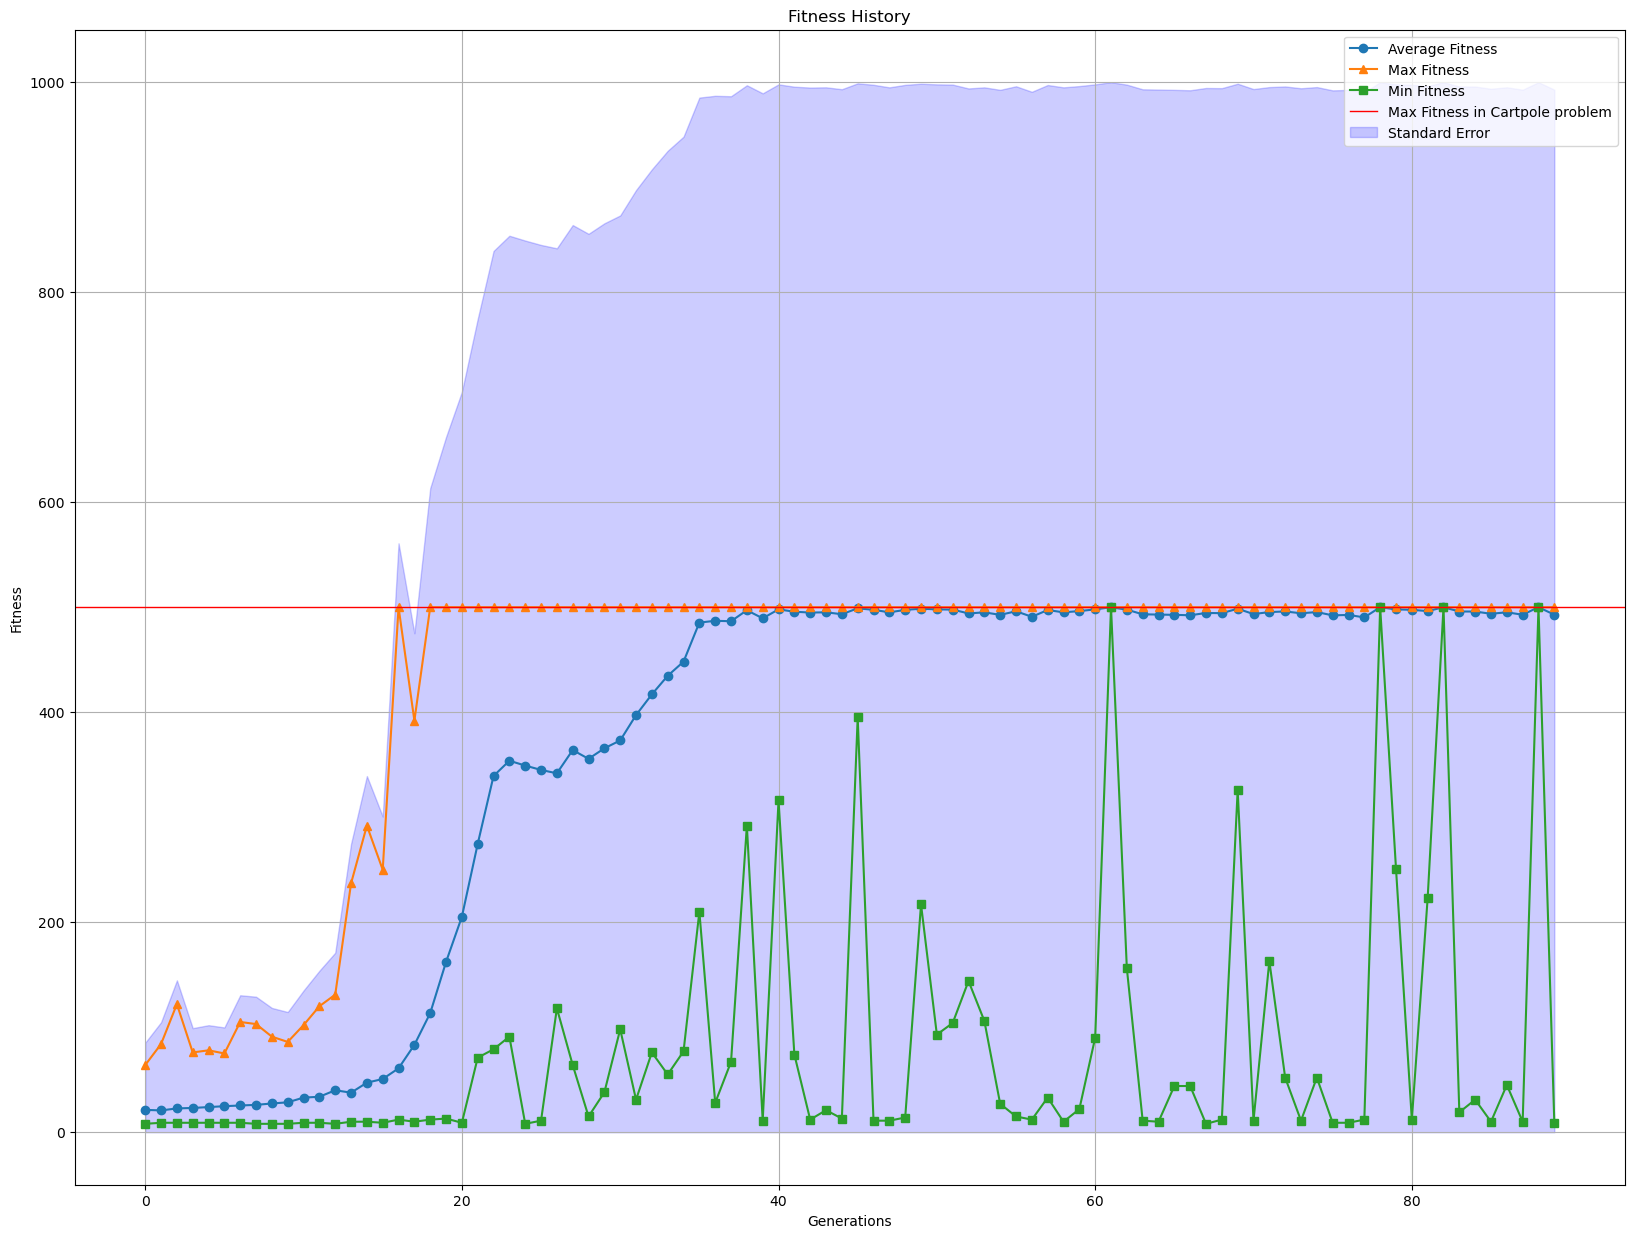

In [12]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(90), np.array(history)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(90), np.array(history)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(90), np.array(history)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.axhline(y=500, color='r', linewidth=1, label='Max Fitness in Cartpole problem')
plt.fill_between(np.arange(90), 0, np.array(history)[:,0] + np.array(history)[:,1],
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()